In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import colormaps
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

%matplotlib inline

In [2]:
counts = pd.read_csv('fig2_uc_counts.csv')

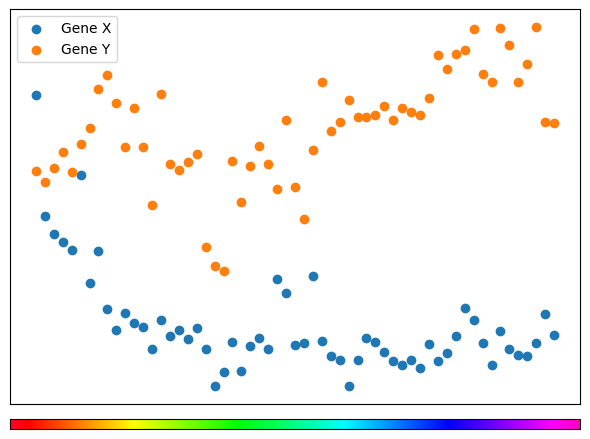

In [3]:
cbar_rel = 0.025
fig, (ax, cax) = plt.subplots(2, 1, height_ratios=[1-cbar_rel, cbar_rel], figsize=(6, 4.5))

xs = np.arange(len(counts))

ax.scatter(xs, counts['EPCAM'], label='Gene X')
ax.scatter(xs, counts['ACTA2'], label='Gene Y')
ax.set_xticks([])
ax.set_yticks([])

cmap = colormaps['gist_rainbow']
sm = ScalarMappable(norm=Normalize(vmin=0, vmax=len(counts) - 1), cmap=cmap)
fig.colorbar(sm, cax, orientation="horizontal")

cax.set_xticks([])
cax.set_yticks([])

ax.legend()

fig.tight_layout()

fig.savefig('fig1-traj.png')
fig.savefig('fig1-traj.pdf')

In [4]:
import sys
sys.path.append('/mnt/data1/spatial/tissue-alignment/traversal')

from io_utils import read_transcription_data

In [5]:
counts = read_transcription_data('/mnt/data1/spatial/data/colon/CD/B')

In [44]:
temp = counts.to_numpy()[:, counts.sum(axis=0) > 1500]

In [45]:
temp.shape

(2664, 1884)

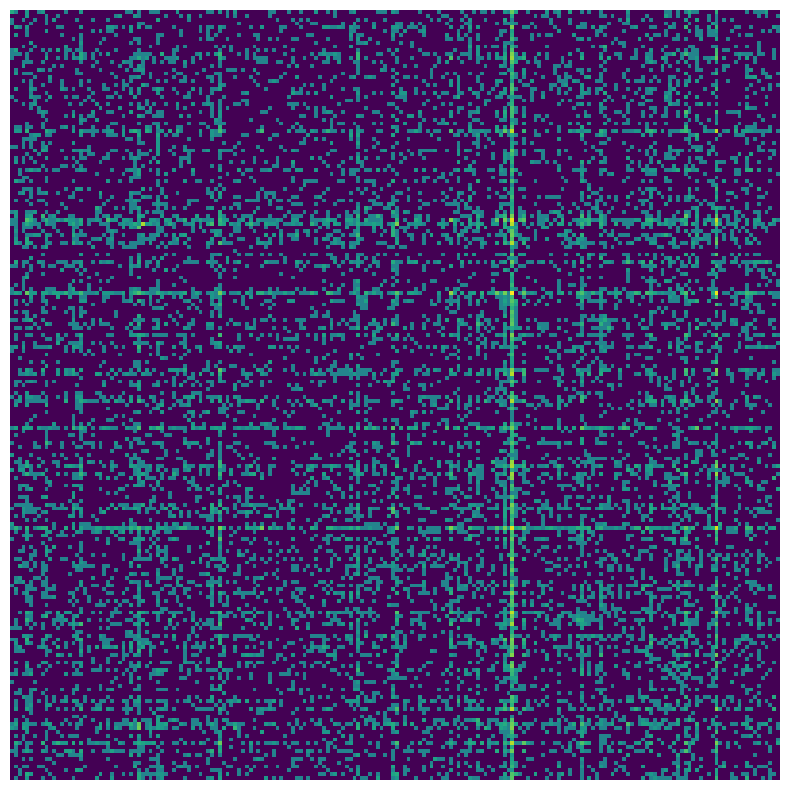

In [49]:
plt.close()
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(temp[:200,:200], cmap='viridis', interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()
fig.savefig('fig1-heatmap.png')
fig.savefig('fig1-heatmap.pdf')

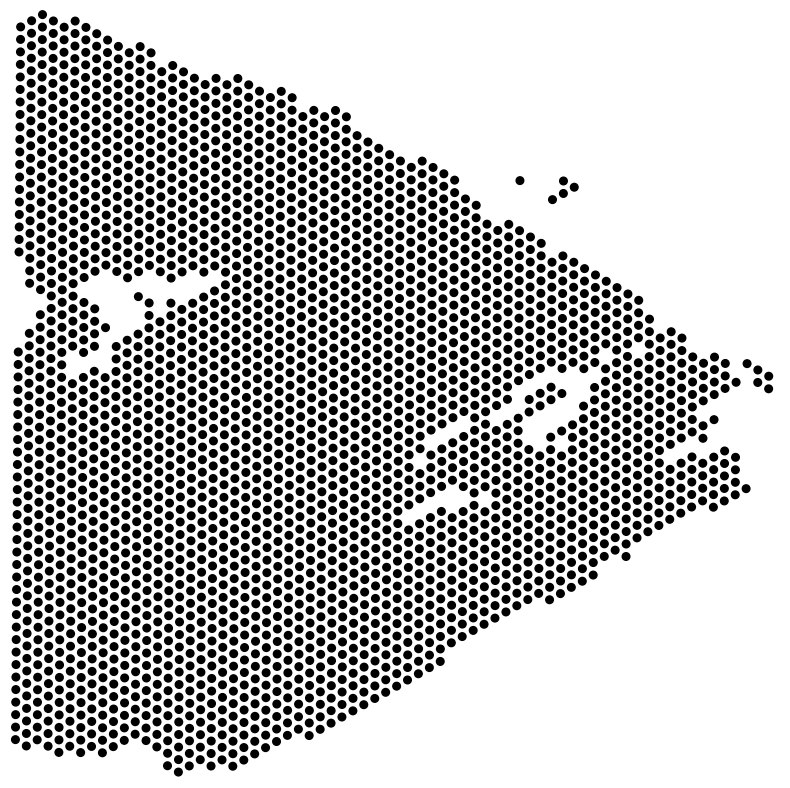

In [53]:
from io_utils import read_image, read_spatial_data

cd_path = '/mnt/data1/spatial/data/colon/CD/B'
cd_im = read_image(cd_path, False)
cd_pos_df, cd_spot_radius = read_spatial_data(cd_path, False)

from matplotlib.collections import PatchCollection
from matplotlib.colors import to_rgba
from matplotlib.patches import Circle

cd_circs = PatchCollection(
    [Circle((x, y), cd_spot_radius) for x, y in cd_pos_df[["x", "y"]].to_numpy()],
    picker=True,
)
cd_facecolors = np.asarray([list(to_rgba("black"))] * len(cd_pos_df))
cd_edgecolors = np.asarray([list(to_rgba("black"))] * len(cd_pos_df))
cd_alphas = np.full(len(cd_pos_df), 1)
cd_circs.set_facecolor(cd_facecolors)
cd_circs.set_edgecolor(cd_edgecolors)
cd_circs.set_alpha(cd_alphas)

plt.close()
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(cd_im, alpha=0)
ax.set_axis_off()
ax.add_collection(cd_circs)
ax.set_xlim([cd_pos_df['x'].min() - 10, cd_pos_df['x'].max() / 10 * 9 + 75])
ax.set_ylim([cd_pos_df['y'].min() + 10, cd_pos_df['y'].max() + 10])
fig.tight_layout()
fig.savefig('fig1-grid.png', transparent=True)
fig.savefig('fig1-grid.pdf', transparent=True)